# Duplicates Detection Method

In [292]:
### IMPORT PACKAGES

import sys
import pandas as pd
import numpy as np
import json
import kshingle as ks
import random 
import string
import re
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import itertools
import math
import tqdm
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

### 1.1 Load Data

In [9]:
# Open JSON file
with open('TVs-all-merged.json') as f:
  data = json.load(f)

print(type(data))

print(len(data.keys()))

<class 'dict'>
1262


### 2.1 Define all functions

In [515]:
# Function for number of product descriptions
def total_products(data):
    total_products = 0
    for key in data.keys():
        total_products += len(data[key]) 
    print(total_products)

# Split descriptions to make separate dictionary
def get_product_dicts(data):
    product_dicts = {}
    i=0
    for key in data.keys():
        for product in data[key]:
            product_dicts[i] = product
            i += 1
    return product_dicts

# Remove type of description and 
def get_products(product_dicts):
    products = {}
    i = 0
    for key in product_dicts.keys():
        products[i] = []
        for description in product_dicts[key]:
            if description == 'title' :
                products[i].append(product_dicts[key][description])
            elif description == 'featuresMap':
                for feature in product_dicts[key][description].keys():
                    products[i].append(product_dicts[key][description][feature])
        i += 1
    return products

# Get all titles for bootstrapping
def get_titles(products):
    titles = []
    for product in products:
        titles.append(products[product]["title"])
    return titles

# Bootstrap function
def create_bootstraps(b, products):    
    train_set = []
    test_set = []
    for i in range(b):
        boot = random.choices(range(len(products)), k=len(products))
        boot_noDuplicates = list(set(boot))
        complete = list(range(len(boot)))
        train_set.append(sorted(boot))
        test = list(set(complete) - set(train_set[i]))
        test_set.append(test)
    return train_set, test_set, boot_noDuplicates


# Extract model words title from key-value pairs
def extract_mw(products):
    model_words = []
    for key in products.keys():
        title_mw = ["".join(x[0]) for x in re.findall(r'([a-zA-Z0-9]*(([0-9]+[^0-9, ]+)|([^0-9, ]+[0-9]+))[a-zA-Z0-9]*)', products[key][-1])]
        for subitem in title_mw:
            if subitem is not None and subitem not in model_words:
                model_words.append(subitem)
        for item in products[key][:-1]:
            keyvalue_mw = re.findall(r'(ˆ\d+(\.\d+)?[a-zA-Z]+$|ˆ\d+(\.\d+)?$)', item)
            if keyvalue_mw is not None and keyvalue_mw not in model_words:
                model_words.append(keyvalue_mw)
    for mw in model_words:
        if not isinstance(mw, str):
            model_words.remove(mw)
    return model_words

# Count occurrence of a string in whole dictionary
def occurrence_counter(products, string):
    count = 0
    for key in products.keys():
        for item in products[key]:
            count += item.count(string)
    print(count)

# Data cleaning
def clean_data(products_raw):
    products = {}
    for key in products_raw.keys():
        products[key] = []
        for item in products_raw[key]:
            item = item.replace('"', 'inch').replace('-inch', 'inch').replace('inches', 'inch').replace(' inch', 'inch').replace('inch', 'inch')
            item = item.replace('Hertz', 'hz').replace('hertz', 'hz').replace('Hz', 'hz').replace('HZ', 'hz').replace('-hz', 'hz').replace('hz', 'hz')
            products[key].append(item)
    return products

# Create binary matrix
def get_bin_matrix(products, model_words):    
    binary_matrix = None
    i = 0
    for product in products:
        bin_list = []
        for mw in model_words:
            if any(mw in item for item in products[product]):
                bin_list.append(1)
            else:
                bin_list.append(0) 
        bin_vec = np.array(bin_list)
        if i == 0:
            binary_matrix = bin_vec # Initialize matrix
        else:
            binary_matrix = np.c_[binary_matrix, bin_vec] # Append column for product i
        i += 1
    return binary_matrix

# Generate random prime number
def primeNumbers(a,b):
    list_of_primes = []
    for n in range(a,b):
        isPrimeNumber = True
        for number in range(2,n):
            if n % number == 0:
                isPrimeNumber == False
        if isPrimeNumber == True:
            list_of_primes.append(n)
    return list_of_primes

# Gernerate hash functions
def hash_funcs(model_words, binary_matrix):
    n = round(len(model_words)/2) # Number of hash functions equal to half of the model words 
    primes = primeNumbers(n, n + 200)
    p = random.choice(primes)
    a = []
    b = []
    for i in range(0,n):
        a.append(random.randint(0, len(model_words)))
        b.append(random.randint(1,len(model_words)))
    hash_func_values = [[0 for i in range(len(binary_matrix))] for j in range(n)]
    for j in range(0, len(a)):
        for i in range(0, len(binary_matrix)):
            hash_func_values[j][i] = (a[j]+b[j]*i)%p
    return hash_func_values

# Create Signature Matrix
def MinHash(binary_matrix, model_words, products, hash_func_values):
    columns = list(range(len(binary_matrix)))
    binary_matrix_pd = pd.DataFrame(binary_matrix, columns)
    transposed_binary_matrix = binary_matrix_pd.transpose() # Slide 40 of LSH lecture, sort matrix to compute hashed values once for each row
    n = round(len(model_words)/2)
    sig = [float('inf')]*n 
    signatures = [sig]*(len(transposed_binary_matrix))
    signatures = np.matrix(signatures)

    for i in range(len(transposed_binary_matrix)): # rows, represent product descriptions
        for j in range(len(binary_matrix_pd)): # columns, represent model words
            if transposed_binary_matrix.iloc[i,j] == 1: # Check the permutations
                for other in range(len(hash_func_values)): # Check for other hashed values
                    if hash_func_values[other][j] < signatures[i,other]: # value per hash
                        signatures[i,other] = hash_func_values[other][j]

    signatures = np.transpose(signatures)
    signatures = signatures.astype(int)
    #signatures = pd.DataFrame(signatures, index=products.keys())
    #signatures.columns = np.arange(1, n+1)
    
    return signatures

# Create LSH function
def LSH(signature_matrix, products, model_words, r):

    signature_matrix = pd.DataFrame(signature_matrix)
    blength = r  # r in LSH method
    n = round(len(model_words)/2)
    total_bands = int(n/blength) # b in LSH
    sigband = []

    if type(total_bands) is not int:
        raise Exception("Number of bands is not integer-valued. Input other band length.")

    # Get the signatures per band in a list
    for i in range(1, total_bands+1):
        if i == 1:
            sigband.append(signature_matrix.iloc[0:blength])
        else:
            sigband.append(signature_matrix.iloc[blength*(i-1):blength*i])

    # Make matrix with 'rows in a band for one column' combined as elements
    bands_to_be_combined = np.zeros((len(sigband), len(products)))
    band_matrix = pd.DataFrame(bands_to_be_combined, columns=products.keys())

    value = ""    
    for band in range(len(sigband)):
        for j in range(len(sigband[0].iloc[0,:])):
            for i in range(len(sigband[0])):
                value += str(sigband[band].iloc[i,j])
            band_matrix.iloc[band,j] = value
            value = ""
   
    # Create empty candidate matrix
    candidates = np.zeros((len(products),len(products)))
    candidates = pd.DataFrame(candidates).astype(int)

    # All candidates put in matrix of candidate-pairs
    for i in range(len(band_matrix)): # For each of the 74 bands
        values_per_band = band_matrix.iloc[i,:]
        #values_per_band = values_per_band.to_numpy()
        txt = "Type of values per band is {type}"
        #print(txt.format(type = type(values_per_band)))
        #values_per_band = np.sort(np.int64(values_per_band)) # Sort the values from small to large
        values_per_band = values_per_band.sort_values()
       
        major = [] # final buckets
        minor = [] # temporary buckets per band
    
        try:
            for j in range(len(values_per_band)-1): #range(len(values_per_band)-1): # For each product
                if j == len(values_per_band)-2:
                    minor.append(j)
                    minor.append(j+1)
                    major.append(minor)
                elif values_per_band[j+1] == values_per_band[j]:
                    minor.append(j)
                else:
                    minor.append(j)
                    major.append(minor)
                    minor.clear()
        except KeyError:
            pass
        
        combinations = []
        for x in range(len(major)):
            for subset in itertools.combinations(major[x], 2): # Check the possible candidates
                combinations.append(tuple(subset))
               
        for comb in range(len(combinations)):
            candidates[int(combinations[comb][0])][int(combinations[comb][1])] = 1
            candidates[int(combinations[comb][1])][int(combinations[comb][0])] = 1
           
    # Convert candidates to lower triangular
    arr_candidates = candidates.to_numpy()
    candidate_matrix = np.tril(arr_candidates)

    return candidate_matrix

# Get number of comparisons
def number_of_comparisons(candidate_matrix):
    number_of_comparisons = np.sum(candidate_matrix)
    
    return number_of_comparisons 

# Function for total number of comparisons
def total_possible_comparisons(candidate_matrix):
    ones_lower = np.tril(np.ones((len(candidate_matrix),len(candidate_matrix))))
    np.fill_diagonal(ones_lower, 0)
    total_possible = np.sum(ones_lower)
    
    return total_possible

# Function for Pair Quality
def pairquality(duplicates_found, num_of_comp):
    pq = duplicates_found / num_of_comp

    return pq

# Function for Pair Completeness
def paircompleteness(duplicates_found, total_real_duplicates):
    pc = duplicates_found / total_real_duplicates

    return pc

# Function for F1*
def F1star(pq, pc):
    F1star_score = (pq + pc)/2

    return F1star_score

# Function for F1
def F1(TP, FP, TN, FN):
    precision = (TP+1) / (TP+1 + FP)
    recall = (TP+1) / (TP+1 + FN)
    F1 = (2*precision*recall)/(precision+recall)

    return F1

# Function for fraction of comparisons
def frac_of_comparisons(num_of_comp, total_possible):
    frac = num_of_comp/total_possible

    return frac
    
# Function to check all real duplicates and also returns total 
def realduplicates(product_dicts):
    real_duplicate_matrix = np.zeros((len(product_dicts.keys()), len(product_dicts.keys())))
    #real_duplicate_matrix = pd.DataFrame(real_duplicate_matrix)

    for product_i in product_dicts.keys():
        for product_j in product_dicts.keys():
            if product_dicts[product_i]['modelID'] == product_dicts[product_j]['modelID']:
                if product_i != product_j:
                    real_duplicate_matrix[product_i, product_j] = 1
    
    total_realduplicates = np.sum(real_duplicate_matrix)/2
    real_duplicate_matrix = real_duplicate_matrix.astype(int)

    return real_duplicate_matrix, total_realduplicates

# Candidate evaluation
def evaluate_candidates(candidate_matrix, real_duplicate_matrix, products, binary_matrix, t):
    detected_duplicates_J = np.zeros((len(candidate_matrix),len(candidate_matrix)))
    detected_duplicates_C = np.zeros((len(candidate_matrix),len(candidate_matrix)))
    
    for i in range(len(candidate_matrix)):
        for j in range(len(candidate_matrix)):
            if candidate_matrix[i,j] == 1:
                title1 = products[list(products.keys())[i]][-1]
                title2 = products[list(products.keys())[j]][-1]
                comp = [title1,title2]
                vectorizer = CountVectorizer().fit_transform(comp)
                vectors = vectorizer.toarray()
                if detected_duplicates_J[i,j] == 0:
                    detected_duplicates_J[i,j] = (1 if jaccard_score(binary_matrix[:,i], binary_matrix[:,j], average='micro') >= t else 0)
                if detected_duplicates_C[i,j] == 0:
                    detected_duplicates_C[i,j] = (1 if cosine_similarity(vectors)[0,1] >= t else 0)
    FN_c = 0
    FP_c = 0
    TN_c = 0
    TP_c = 0
    FN_j = 0
    FP_j = 0
    TN_j = 0
    TP_j = 0
    
    detected_duplicates_C  = detected_duplicates_C.astype(int)
    detected_duplicates_J = detected_duplicates_J.astype(int)

    for i in range(len(detected_duplicates_C)):
        for j in range(len(detected_duplicates_C)):
            if detected_duplicates_C[i,j] == 0 and real_duplicate_matrix[i,j] == 0:
                TN_c += 1
            elif detected_duplicates_C[i,j] == 1 and real_duplicate_matrix[i,j] == 0:
                FP_c += 1
            elif detected_duplicates_C[i,j] == 0 and real_duplicate_matrix[i,j] == 1:
                FN_c += 1
            elif detected_duplicates_C[i,j] == 1 and real_duplicate_matrix[i,j] == 1:
                TP_c += 1

    for i in range(len(detected_duplicates_J)):
        for j in range(len(detected_duplicates_J)):
            if detected_duplicates_J[i,j] == 0 and real_duplicate_matrix[i,j] == 0:
                TN_j += 1
            elif detected_duplicates_J[i,j] == 1 and real_duplicate_matrix[i,j] == 0:
                FP_j += 1
            elif detected_duplicates_J[i,j] == 0 and real_duplicate_matrix[i,j] == 1:
                FN_j += 1
            elif detected_duplicates_J[i,j] == 1 and real_duplicate_matrix[i,j] == 1:
                TP_j += 1

    return TP_c, TN_c, FP_c, FN_c, TP_j, TN_j, FP_j, FN_j




### 2.2 Duplicate Detection Model

In [492]:
def full_detection_model(products, product_dicts, rows, threshold):    
    t = threshold
    r = rows
    model_words = extract_mw(products)

    binary_matrix = get_bin_matrix(products, model_words)
    
    hash_func_values = hash_funcs(model_words, binary_matrix)

    signature_matrix = MinHash(binary_matrix, model_words, products, hash_func_values)

    candidate_matrix = LSH(signature_matrix, products, model_words, r)

    real_duplicate_matrix, total_realdup = realduplicates(product_dicts)

    TP_c, TN_c, FP_c, FN_c, TP_j, TN_j, FP_j, FN_j = evaluate_candidates(candidate_matrix, real_duplicate_matrix, products, binary_matrix, t)

    F1j = F1(TP=TP_j, FP=FP_j, TN=TN_j, FN=FN_j)
    F1c = F1(TP=TP_c, FP=FP_c, TN=TN_c, FN=FN_c)
    num_of_comp = number_of_comparisons(candidate_matrix)
    total_possible_comp = total_possible_comparisons(candidate_matrix)
    fraction = frac_of_comparisons(num_of_comp, total_possible_comp)
    pq_c = pairquality(TP_c, num_of_comp)
    pq_j = pairquality(TP_j, num_of_comp)
    pc_c = paircompleteness(TP_c, total_realdup)
    pc_j = paircompleteness(TP_j, total_realdup)

    F1j = F1(TP=TP_j, FP=FP_j, TN=TN_j, FN=FN_j)
    F1c = F1(TP=TP_c, FP=FP_c, TN=TN_c, FN=FN_c)
    F1star_c = F1star(pq_c, pc_c)
    F1star_j = F1star(pq_j, pc_j)

    return fraction, F1c, F1j, F1star_c, F1star_j





### For each bootstrap

In [529]:
product_dicts = get_product_dicts(data)

products_raw = get_products(product_dicts)

products = clean_data(products_raw)
num_of_bootstraps = 5
train_set, test_set, boot_noDuplicates = create_bootstraps(num_of_bootstraps, products)

outcomes3 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=3, threshold=0.2)
    outcomes3.append(outcome)

frac_avg3 = (outcomes3[0][0]+outcomes3[1][0]+outcomes3[2][0]+outcomes3[3][0]+outcomes3[4][0])/5
F1c_avg3 = (outcomes3[0][1]+outcomes3[1][1]+outcomes3[2][1]+outcomes3[3][1]+outcomes3[4][1])/5
F1j_avg3 = (outcomes3[0][2]+outcomes3[1][2]+outcomes3[2][2]+outcomes3[3][2]+outcomes3[4][2])/5
F1star_c_avg3 = (outcomes3[0][3]+outcomes3[1][3]+outcomes3[2][3]+outcomes3[3][3]+outcomes3[4][3])/5
F1star_j_avg3 = (outcomes3[0][4]+outcomes3[1][4]+outcomes3[2][4]+outcomes3[3][4]+outcomes3[4][4])/5

outcomes6 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=6, threshold=0.2)
    outcomes6.append(outcome)

frac_avg6 = (outcomes6[0][0]+outcomes6[1][0]+outcomes6[2][0]+outcomes6[3][0]+outcomes6[4][0])/5
F1c_avg6 = (outcomes6[0][1]+outcomes6[1][1]+outcomes6[2][1]+outcomes6[3][1]+outcomes6[4][1])/5
F1j_avg6 = (outcomes6[0][2]+outcomes6[1][2]+outcomes6[2][2]+outcomes6[3][2]+outcomes6[4][2])/5
F1star_c_avg6 = (outcomes6[0][3]+outcomes6[1][3]+outcomes6[2][3]+outcomes6[3][3]+outcomes6[4][3])/5
F1star_j_avg6 = (outcomes6[0][4]+outcomes6[1][4]+outcomes6[2][4]+outcomes6[3][4]+outcomes6[4][4])/5

outcomes9 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=9, threshold=0.2)
    outcomes9.append(outcome)

frac_avg9 = (outcomes9[0][0]+outcomes9[1][0]+outcomes9[2][0]+outcomes9[3][0]+outcomes9[4][0])/5
F1c_avg9 = (outcomes9[0][1]+outcomes9[1][1]+outcomes9[2][1]+outcomes9[3][1]+outcomes9[4][1])/5
F1j_avg9 = (outcomes9[0][2]+outcomes9[1][2]+outcomes9[2][2]+outcomes9[3][2]+outcomes9[4][2])/5
F1star_c_avg9 = (outcomes9[0][3]+outcomes9[1][3]+outcomes9[2][3]+outcomes9[3][3]+outcomes9[4][3])/5
F1star_j_avg9 = (outcomes9[0][4]+outcomes9[1][4]+outcomes9[2][4]+outcomes9[3][4]+outcomes9[4][4])/5

outcomes18 = []
for j in range(num_of_bootstraps):
    products_boot = {}
    for index in test_set[j]:
        products_boot.update({index : products[index]})
    outcome = full_detection_model(products_boot, product_dicts, rows=18, threshold=0.2)
    outcomes18.append(outcome)

frac_avg18 = (outcomes18[0][0]+outcomes18[1][0]+outcomes18[2][0]+outcomes18[3][0]+outcomes18[4][0])/5
F1c_avg18 = (outcomes18[0][1]+outcomes18[1][1]+outcomes18[2][1]+outcomes18[3][1]+outcomes18[4][1])/5
F1j_avg18 = (outcomes18[0][2]+outcomes18[1][2]+outcomes18[2][2]+outcomes18[3][2]+outcomes18[4][2])/5
F1star_c_avg18 = (outcomes18[0][3]+outcomes18[1][3]+outcomes18[2][3]+outcomes18[3][3]+outcomes18[4][3])/5
F1star_j_avg18 = (outcomes18[0][4]+outcomes18[1][4]+outcomes18[2][4]+outcomes18[3][4]+outcomes18[4][4])/5




815     10212316
1442    10213316
913     10213316
1599    10710316
1573    10712314
          ...   
1067      928816
199       928816
408       929816
863       929816
228       973816
Name: 0, Length: 591, dtype: object
1238    1037841
338     1090119
1544     110071
1428     111041
904      111416
         ...   
582      996427
494      996448
1451     998848
1406     998848
1100      99926
Name: 1, Length: 591, dtype: object
75      1041142
1529    1041542
904     1041542
120     1041542
84      1041552
         ...   
1376      99152
212       99232
380       99662
1195      99802
1377      99842
Name: 2, Length: 591, dtype: object
737       03399
487     1023359
388     1033151
741     1041159
125    10412119
         ...   
429        9341
752      946127
704     9533145
676       96231
601     9810359
Name: 3, Length: 591, dtype: object
114       1013642
1093    111162182
1382        11210
1342        11222
195        112342
          ...    
1183       937042
244        9370

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


615         02312
79        1001721
1607      1016447
822       1032321
1369    105137201
          ...    
965        942321
820         95821
662         96821
158        992321
1490       996886
Name: 0, Length: 571, dtype: object
1099       01101
691        01101
1100       01101
130         0113
1198        0176
          ...   
939        93198
1170    95127271
214     95253271
782        96124
1075       99146
Name: 1, Length: 571, dtype: object
460       018105
575      1015572
327       106232
321        11507
318       123870
          ...   
365       710710
358        89843
338       911243
1125      936843
592     99120109
Name: 2, Length: 571, dtype: object
562      012176
448      101217
708      101217
1017     101217
890      101241
         ...   
1044    9969143
392      996917
939     9969182
460       99692
149      996974
Name: 3, Length: 571, dtype: object
1579      0780
837      07811
156      07811
692      07811
1472     07811
         ...  
279     997880
133

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


31        1011164
893     101122103
644       1041164
1171      1041164
172       1048064
          ...    
1611        92321
1313       951158
225        951164
366        951164
697        952337
Name: 0, Length: 572, dtype: object
959         0741
966      1005810
9       10110158
169      1011158
644     10125158
          ...   
838      8761158
1308     8858154
643        91158
1211    91178118
981      9716346
Name: 1, Length: 572, dtype: object
785         0837
41          0837
1322     1001724
725     10021899
1315     1021732
          ...   
1168       98176
992         9824
1352      982924
613       984761
1388       99850
Name: 2, Length: 572, dtype: object
1175     010870
77      0133193
1479     013370
366      013370
967       02970
         ...   
415      993770
965      998170
52       998170
212      998170
671      998179
Name: 3, Length: 572, dtype: object
919         01635
1255    100168188
1121       107035
767        110968
752        115168
          ...    


/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


947       0111
697       0111
1035      0111
784       0111
1352      0111
         ...  
1271     88385
338      88385
768       8839
512     963511
673      96353
Name: 0, Length: 594, dtype: object
1009       01062
1412      014212
338      0142159
155       014227
414      0169169
          ...   
588       993412
587     99358148
1244      994312
15        994327
1461      994327
Name: 1, Length: 594, dtype: object
896     10122738
87        103236
1618     1051110
298      1051110
830       105112
          ...   
473         9502
681        96510
874        97438
184        97450
1579       97742
Name: 2, Length: 594, dtype: object
1031    107152139
784     107188139
541     107188139
604     107188139
208      10720111
          ...    
188        952634
1319       952634
271        952634
1435       952634
1320       952634
Name: 3, Length: 594, dtype: object
1000     1031327
1242     1071023
1589    10713623
344     10713623
1306    10713623
          ...   
1090     9712615


/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1465        0146
233        06268
1483      101047
646     10231103
246        10627
          ...   
1619      916268
1133        9196
342        91968
726         9620
33        963136
Name: 0, Length: 596, dtype: object
1582       03332
328        05526
1484     1003332
926       103311
945      1041189
          ...   
753         9339
1542      936125
1095      937218
735       963352
900     97106107
Name: 1, Length: 596, dtype: object
752       03640
419      101927
641     1041540
1119    1051040
169     1051540
         ...   
283        9902
1484       9904
711        9904
1533       9904
1335       9904
Name: 2, Length: 596, dtype: object
572      0117104
1540    10021252
1196     1017073
55      10269169
615      1110762
          ...   
1201     9426942
412      9616744
1559     9620510
1088     9621852
1285     9621852
Name: 3, Length: 596, dtype: object
981       021234
292     10070174
1196      102128
55        109032
683      1093045
          ...   
380        82132


/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1412       030137871426
318          0438871426
1502       100776551426
1506    101101012471144
408       1016410691436
             ...       
193         97742281296
681         97775871436
622        977768717926
1020       977778871426
619          9904487113
Name: 0, Length: 591, dtype: object
609          016245189
323      1007691011822
682       101404513825
386     10412457469884
111      1048522143380
             ...      
505         9856145384
1129        9856211328
1384        9856215356
251          985651397
1417         985665538
Name: 1, Length: 591, dtype: object
748       012981943956
247        10241447482
1279       10324144433
453     10721221777468
278      1120228111951
             ...      
185     94772481349173
803       967228944460
217         9672813959
1368       96728414460
388      9712281077960
Name: 2, Length: 591, dtype: object
829          035732631
1169     1003532567081
1158    10035326939135
97        100353269634
698      1005767696321
       

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


79       10105331276812
481       1011101542168
910       1017111152112
567     103811492318272
891         11058976812
             ...       
358        757225568116
1056         7578151912
103      76398811916116
155         79225568116
575       9439111192112
Name: 0, Length: 571, dtype: object
119       10312396312024
695      103123963520132
903      103123963520250
626      103123963520308
284       10314196152022
              ...       
308        9124152796120
1468    9124213139256168
873       91249618318214
640         912496273010
1592      91874218318168
Name: 1, Length: 571, dtype: object
1331          01933922929
1528           0333921523
206           08339774129
703         1012411726311
1207        1012411726311
              ...        
1069          82392632911
515              92392335
666      9767221200407119
1259    98221247245137107
1592        9833169605123
Name: 2, Length: 571, dtype: object
1520    1241510018073165
93        12419100185345
608         12419

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


936         0219109622
157      1001437106210
539      1089118496522
450      1094557142206
230      1119194910622
             ...      
298      8911264157965
496     93208191903176
1482        9419118263
1481       94191187663
77         99974910822
Name: 0, Length: 572, dtype: object
476        10181668209
1502    10181821032063
827       104124366160
1237      104814366163
1382      104818265011
             ...      
11        955353662040
846     95818210312820
664     98102710014137
645       982610811286
1198      988123458363
Name: 1, Length: 572, dtype: object
77      01407863108324
462       041786310815
984       042061408166
1482      092165410815
1481      092166510815
             ...      
588        92090136015
465     93116141631110
1489      932016281110
1251    99196776351243
720       994178632466
Name: 2, Length: 572, dtype: object
1067     101211360184127
533       10196561567024
568        1042156122437
1578      10487297216337
1432       1071229126937
        

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


78      10517073163164
977       105203734834
1297     1055116414970
913         1055354834
1501        1055354834
             ...      
1511         945354834
736          945354834
1585         945354834
1589         945354834
513         9482474822
Name: 0, Length: 594, dtype: object
1066       035147282369
1009         0353963715
906        035451602345
579          0355169315
1450        03575442345
             ...       
1425         9877210915
522        987721610715
737          9877216915
1168    987745100107159
516         98778769159
Name: 1, Length: 594, dtype: object
1036    10518525032131159
1202      111305155358028
461         1299519436354
1         135149198165184
1211     1351492481865184
              ...        
774        93107194363149
1261      931072501624059
578           93111943972
1182         931710061128
1481         939519436312
Name: 2, Length: 594, dtype: object
496      10512111228089
463     111302753204127
262       1119027377241
956        117027

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1472      0150422923
1529    015100462917
1559    015107462917
1353    015109542917
753     015124102917
            ...     
1420    888746662923
126     888758619587
302      88875862977
944      88875862977
6        88875862977
Name: 0, Length: 596, dtype: object
4             0163945132
937          01657584826
786         101653585135
995          10372570153
1523       1061659585135
              ...       
867         818059584134
170         818059588129
1561    8213631517028826
950            864556118
554          98059582635
Name: 1, Length: 596, dtype: object
735           045292679101
1420      1021291732070137
1416      1021411375970137
292     102141173237122137
942        102151225070137
               ...        
718          8931255970125
842        955112250153101
1474       965112211770137
470            97559727029
770        981651614470101
Name: 2, Length: 596, dtype: object
1020         10027179388
741        1021027352835
926         102420713253
440     102421

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


588       01021460655568755
130       01071418653844465
381      010714603568122575
156      010714606555116575
670       01111413555122755
               ...         
455       96226460655580745
1401     963840424455592015
896     9639276080119122835
447       99165760561314385
120        9938732565517525
Name: 0, Length: 591, dtype: object
896           24704654327626877
1576        2471214673269138131
463       247124467632761733577
1518     2471304676327617317077
343     24714713999532511825186
                 ...           
1161         949946763276428131
215          949946763276933577
1096         949946763276933577
855          949946984838243568
358          949946985776123568
Name: 1, Length: 591, dtype: object
917       052256335181176525
1576      100218335174106554
779       100227335767316792
701       100230137556324147
1548       10023233576613341
                ...         
1528       95462413354833128
1143    95462415655766613328
1331     9546573357611713328
1407   

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


918          07312162928106747
1523    1011788281061381221263
1329         10150281614620411
206        1015766582946178611
1607      10312511282914671267
                 ...          
436         965902829983512157
798        9659028621812712109
171      965999667310212776189
358         967766884024422847
1290          9952270182127259
Name: 0, Length: 571, dtype: object
698              108101102633467638
1201         1082430261216614183288
1125          108722058242479204120
1093       108943022321761403561242
666     119242122296106142249281188
                   ...             
1403                996816165495686
562                 996816572295636
384                 996816575495636
875              997909814269583124
1468              99911476625437636
Name: 1, Length: 571, dtype: object
737       01040241468423125
989        0104024148413125
1585      01040791668425125
1030         01057928264764
490      011115461412444539
               ...         
801      94634079206829

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1335       1112227614371654320
1484       1112527614371134374
962        1112527614371254374
783        1112543444411854394
734        1119108284801134351
                 ...          
808       99371088559926163122
1201    9937108991749926163241
254      993731133215020513157
1290      99482682089926114386
893           9986998140662933
Name: 0, Length: 572, dtype: object
1481        011031012865611537
717           0142171117307787
638          01502101265611787
664           0150210126561917
1442        015031020712861787
                 ...          
1205      96422111171281433635
846        9646211117177699247
1522       9662211112441165101
1290    9666317121417722116635
1393       9694211117652219749
Name: 1, Length: 572, dtype: object
1205          101199142231366458
248              108945153117982
1215          110173651593256414
613       1102121652062138164132
1442          110216520693509814
                  ...           
684         83162565162311911668
1079          8

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


766          0124229232285
546        072242291522836
87          07224229232285
466      07411369612322854
1078      0749415612322833
               ...        
120        943424229421135
1535       944124169212505
1370       947224891482945
6       954816795112922079
1247       998241696425016
Name: 0, Length: 594, dtype: object
673       04976521443587135
724      104911452107529718
302      107670881421126031
972     1081207644694938405
613      108327615063159195
               ...         
586         936654463159286
1          9383764463156276
290      938376966315852135
450      939138444949155286
1184         96178129154326
Name: 1, Length: 594, dtype: object
1608        033679040218021
1352         05199644540707
493          09618020215620
333         097183840213920
932     1001011049531229354
               ...         
1623       9851979454007047
393        9851985344007033
1317       9851985454001959
643      985510183239225454
943     9862779121402226142
Name: 2, Length

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


946         10451021152943129
916     104549472010911013929
1146         1045552115614314
190        104556476301778229
331      10457047102783415129
                ...          
911         90589472016128129
1306      9058982010911015129
1370         9753221396443494
1369      9758521391092254929
1525        97589342062015129
Name: 0, Length: 596, dtype: object
735      1043153523413176237
1370     1046316177431319920
1369    10463261777313199438
761       111167077366997113
711        11131352341762396
                ...         
1429        9080161624366420
0        9087623718663241347
902      9746677261311010464
1362    97701091177313199458
495        97701618241668120
Name: 1, Length: 596, dtype: object
833        016388813198439140
814           025380119843965
274        025388813204843912
1199        02549771376683967
1386        02593881319842131
                ...          
154     998438431321751823994
630      99843888197219184294
1267       998469018571553925
292     9

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


247           0166845201452431261089729836833607145
573         101011639645449625159220161671041425987
617            101022168299944725378947167875395949
100       10115161142014529620147892916167175177436
1408          1012216114201102102592891216683360731
                           ...                     
1095        944416254484522150139162294498222421162
801          95331657604543486871628251662423811597
386     9623296512999118160132012931616912912561386
1517     984410714810724215013121715510386234321287
1518    9844161841072415350163115155103167214221288
Name: 0, Length: 591, dtype: object
1204           04202831121821747741175702116121149102
378      10211131072642967618427642141194812482104191
920     102355228873802366821166455244261112743641114
1428           10313614012374698728573123551625652111
111        104108144291121827077419689126111211273138
                            ...                      
678               79693741102913750302057188323514988
1218          

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1106                 051011329120212375638713372672412
399                05751422937441214636322179583672444
1105            07728315229120571293563217733770672444
328             10111531731705157123564521741277093244
1222               10131532489912557126605484127493216
                             ...                      
816     8073127351701662972743564133321652011459156112
338         809549219170741710835161335109137145913484
1299                  83575885219571213305913951492812
575           8549962913653541191843217612932222275748
1550           902151011322051346211003351433770255788
Name: 0, Length: 571, dtype: object
295               019084202325062415635882661143425
1002        019948420241707613027430273882103143486
115         100157632491254496830130197222465177646
617     1001576324914173491263013019722124225177646
848      100157684491411149126301301972212422517400
                           ...                     
799               90714732849627186561977422917

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


515         110112141418090569513317541172000157
746           1101463014180905695138475271462545
23         1101652118062225611273188862311711157
31             110181414180905695133178662525157
794            110182014180901995131217866252563
                         ...                    
883             96127921760184231276507953534982
690          96128221760184231561814513159311124
952    96129012378723421531276195190119691890158
286               961291470902027631786597225157
367           9673060180625631161357786986996156
Name: 0, Length: 572, dtype: object
621           0110144139017372248256532262415
734            011413213282648189825922624105
83            0114201328274815571029142304115
1246       0114221132891462212425761021034325
1213       0127117914249734820320227622625319
                        ...                  
1115             9911465182746155710290225415
833         991411464653148663554104022553719
5          9918314651903312766519120182563413
561       9

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


1351          101123612157031313132432331055119
1179          101123612157031313132432331435119
508              102523612113031531328339275119
1470             102523612153011931248339273919
81      105411361441213758109743114848464395150
                         ...                   
960                 999280153043131604335274223
5               9993544243164353111247535446623
1303          999431272109304103152833109558123
668              999442472312468313683318699323
268              999574478754419314193351393923
Name: 0, Length: 594, dtype: object
338        112110416793413856294638243431991843893
1058      1121131129591061727214337024403271403812
314           112113672393475146626572440327140313
719     112164205167917812054112857248831272163899
521        112185402392021714014352572412733136922
                           ...                    
184                 763272395835281617024132740212
396              765072393075501012956241375562348
57              765646167034

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


585               01022511612383951320571582512
1319          100453254393483831443087711156512
64      100742113200496527248121911621715995119
770        100743254204383741363711126115756512
188         10074325439878383120378716115756512
                         ...                   
477           998332539912716833640874691159412
536          9983325399127168336408746915782412
1328         9983325399127168336408746915782412
993             9983325399421683364087467159412
1525             998338609512102048120941120412
Name: 0, Length: 596, dtype: object
611          0601522514534923791363639236716152088
208           101109202614935431536206810420782714
922           101162026145847175511164510411836614
34      101871259100911321761176111002740200169619
326            10612320261493549575206458120782714
                           ...                    
301          9239105122142354577350426845581611042
995        981442843141513571356720883950206427136
478             981512026148

/var/folders/j5/542fhs1s6hx3wcjdtj22cy500000gn/T/ipykernel_16686/1363804926.py:254: RuntimeWarning: invalid value encountered in long_scalars
  pq = duplicates_found / num_of_comp


In [531]:
f1c = [F1c_avg3,F1c_avg6,F1c_avg9,F1c_avg18]
f1j = [F1j_avg3, F1j_avg6, F1j_avg9, F1j_avg18]
f1starc = [F1star_c_avg3, F1star_c_avg6, F1star_c_avg9, F1star_c_avg18]
f1starj = [F1star_j_avg3, F1star_j_avg6, F1star_j_avg9, F1star_j_avg18]
fracs = [frac_avg3, frac_avg6, frac_avg9, frac_avg18]


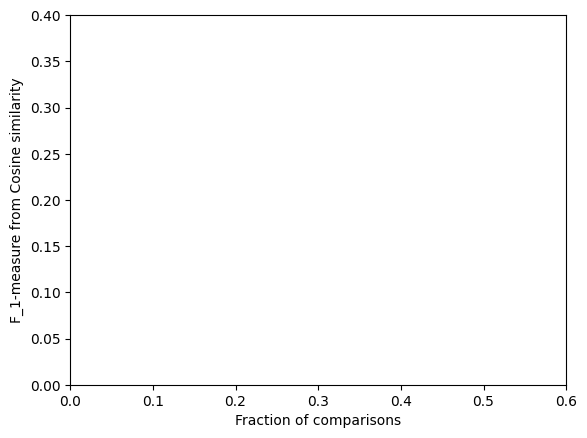

In [532]:
plt.plot(fracs, f1c)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1-measure from Cosine similarity')
plt.savefig('figuref1c.png')
plt.xlim(0,0.6)
plt.ylim(0,0.4)


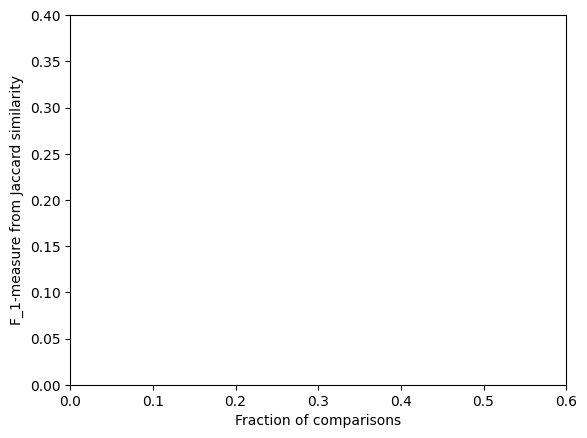

In [533]:
plt.plot(fracs, f1j)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1-measure from Jaccard similarity')
plt.savefig('figuref1j.png')
plt.xlim(0,0.6)
plt.ylim(0,0.4)


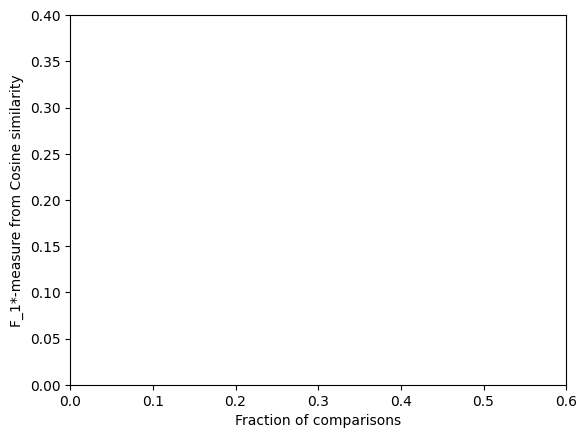

In [534]:
plt.plot(fracs, f1starc)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1*-measure from Cosine similarity')
plt.savefig('figuref1cstar.png')
plt.xlim(0,0.6)
plt.ylim(0,0.4)

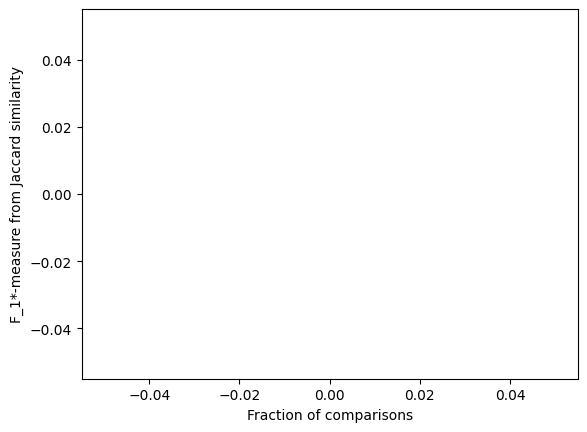

In [536]:
plt.plot(fracs, f1starj)
plt.xlabel('Fraction of comparisons')
plt.ylabel('F_1*-measure from Jaccard similarity')
plt.savefig('figuref1jstar.png')
plt.xlim(0,0.6)
plt.ylim(0,0.4)

In [510]:
sys.maxsize

9223372036854775807